In [ ]:

drive.mount('/content/drive')

In [ ]:
!pip install sentence-transformers
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from typing import List, Tuple
import time
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns


In [ ]:

file_path = '/content/drive/MyDrive/wos_data/merged_file_with_metrics.xlsx'
df = pd.read_excel(file_path)

# Combine title and abstract for each document
df['text'] = df['Article Title'].fillna('') + ' ' + df['Abstract'].fillna('')

# Sample user queries (replace with your own)
user_queries = [
    "coronaviruses",
    "climate change effects",
    "quantum computing advancements"
]

def preprocess_text(text):
    # Handle NaN values and convert to string
    if pd.isna(text):
        return ''
    # Convert to string and lowercase
    return str(text).lower()

# Preprocess the text
df['processed_text'] = df['text'].apply(preprocess_text)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nSample data:")
print(df.head())

# Check for any remaining NaN values
print("\nChecking for NaN values:")
print(df.isna().sum())

# Check data types
print("\nColumn data types:")
print(df.dtypes)

Dataset shape: (10000, 80)
Columns: ['Publication Type', 'Authors', 'Book Authors', 'Book Editors', 'Book Group Authors', 'Author Full Names', 'Book Author Full Names', 'Group Authors', 'Article Title', 'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language', 'Document Type', 'Conference Title', 'Conference Date', 'Conference Location', 'Conference Sponsor', 'Conference Host', 'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses', 'Affiliations', 'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs', 'Funding Orgs', 'Funding Name Preferred', 'Funding Text', 'Cited References', 'Cited Reference Count', 'Times Cited, WoS Core', 'Times Cited, All Databases', '180 Day Usage Count', 'Since 2013 Usage Count', 'Publisher', 'Publisher City', 'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation', 'Journal ISO Abbreviation', 'Publication Date', 'Publication Year', 'Volume', 'Issue', 'Part Number', 'Supplement', 'Special Issue', 'Meeting Abstract'

In [ ]:
# Update the TF-IDF embedding function
def tfidf_embedding(documents: List[str], query: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    vectorizer = TfidfVectorizer()
    doc_vectors = vectorizer.fit_transform(documents)
    query_vector = vectorizer.transform([query])
    return doc_vectors, query_vector, doc_vectors.toarray()

# Update the BERT embedding function
def bert_embedding(documents: List[str], query: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    doc_vectors = model.encode(documents)
    query_vector = model.encode([query])
    return doc_vectors, query_vector, doc_vectors

In [ ]:
def get_top_k_similar(doc_vectors: np.ndarray, query_vector: np.ndarray, k: int = 100) -> List[int]:
    similarities = cosine_similarity(query_vector, doc_vectors).flatten()
    top_k_indices = similarities.argsort()[-k:][::-1]
    return top_k_indices.tolist(), similarities[top_k_indices]

def evaluate_embedding(embedding_func, name: str):
    start_time = time.time()

    all_top_k = []
    all_similarities = []
    all_embeddings = None

    for query in user_queries:
        doc_vectors, query_vector, embeddings = embedding_func(df['processed_text'].tolist(), query)
        if all_embeddings is None:
            all_embeddings = embeddings
        top_k, similarities = get_top_k_similar(doc_vectors, query_vector, k=100)
        all_top_k.append(top_k)
        all_similarities.append(similarities)

    end_time = time.time()

    print(f"\n{name} Embedding Results:")
    print(f"Time taken: {end_time - start_time:.2f} seconds")


    for i, query in enumerate(user_queries):
        print(f"\nQuery: {query}")
        print("Top 5 similar documents:")
        for idx, sim in zip(all_top_k[i][:5], all_similarities[i][:5]):
            print(f"- {df['Article Title'].iloc[idx]} (Similarity: {sim:.4f})")

    return all_top_k, all_similarities, end_time - start_time, all_embeddings

# Run evaluations
tfidf_results = evaluate_embedding(tfidf_embedding, "TF-IDF")
bert_results = evaluate_embedding(bert_embedding, "BERT")




TF-IDF Embedding Results:
Time taken: 9.90 seconds

Query: coronaviruses
Top 5 similar documents:
- Evaluating the Virology and Evolution of Seasonal Human Coronaviruses Associated with the Common Cold in the COVID-19 Era (Similarity: 0.6096)
- Basic virology of SARS-CoV 2 (Similarity: 0.2055)
- Statistical Analysis of Common Respiratory Viruses Reveals the Binary of Virus-Virus Interaction (Similarity: 0.1792)
- Modified Vaccinia Virus Ankara (MVA) as Production Platform for Vaccines against Influenza and Other Viral Respiratory Diseases (Similarity: 0.1412)
- Comparative incidence and burden of respiratory viruses associated with hospitalization in adults in New York City (Similarity: 0.1218)

Query: climate change effects
Top 5 similar documents:
- Climate change and materials virology (Similarity: 0.6248)
- The role of industrial ecology in food and agriculture's adaptation to climate change (Similarity: 0.4907)
- Climate Silence in Sociology? How Elite American Sociology, Environ

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.80k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


BERT Embedding Results:
Time taken: 65.09 seconds

Query: coronaviruses
Top 5 similar documents:
- Virology The evolving coronavirus (Similarity: 0.7989)
- VIRUSES AND VIROLOGY (Similarity: 0.7803)
- THE VIROLOGY OF HEPATITIS-A (Similarity: 0.7756)
- THE VIROLOGY OF HEPATITIS-C (Similarity: 0.7598)
- COVID-19 Epidemiology, Pathophysiology, Transmission, Symptoms (Similarity: 0.7186)

Query: climate change effects
Top 5 similar documents:
- Climate change and materials virology (Similarity: 0.8672)
- Is vegetative area, photosynthesis, or grape C uploading involved in the climate change-related grape sugar/anthocyanin decoupling in Tempranillo? (Similarity: 0.6622)
- Environmental studies and sciences in a time of chaos: problems, contexts, and recommendations (Similarity: 0.6508)
- Plant respiration responses to climate determine geographic distribution (Similarity: 0.6317)
- Socio-Environmental Science, Technology and Sustainability (Similarity: 0.6274)

Query: quantum computing adva

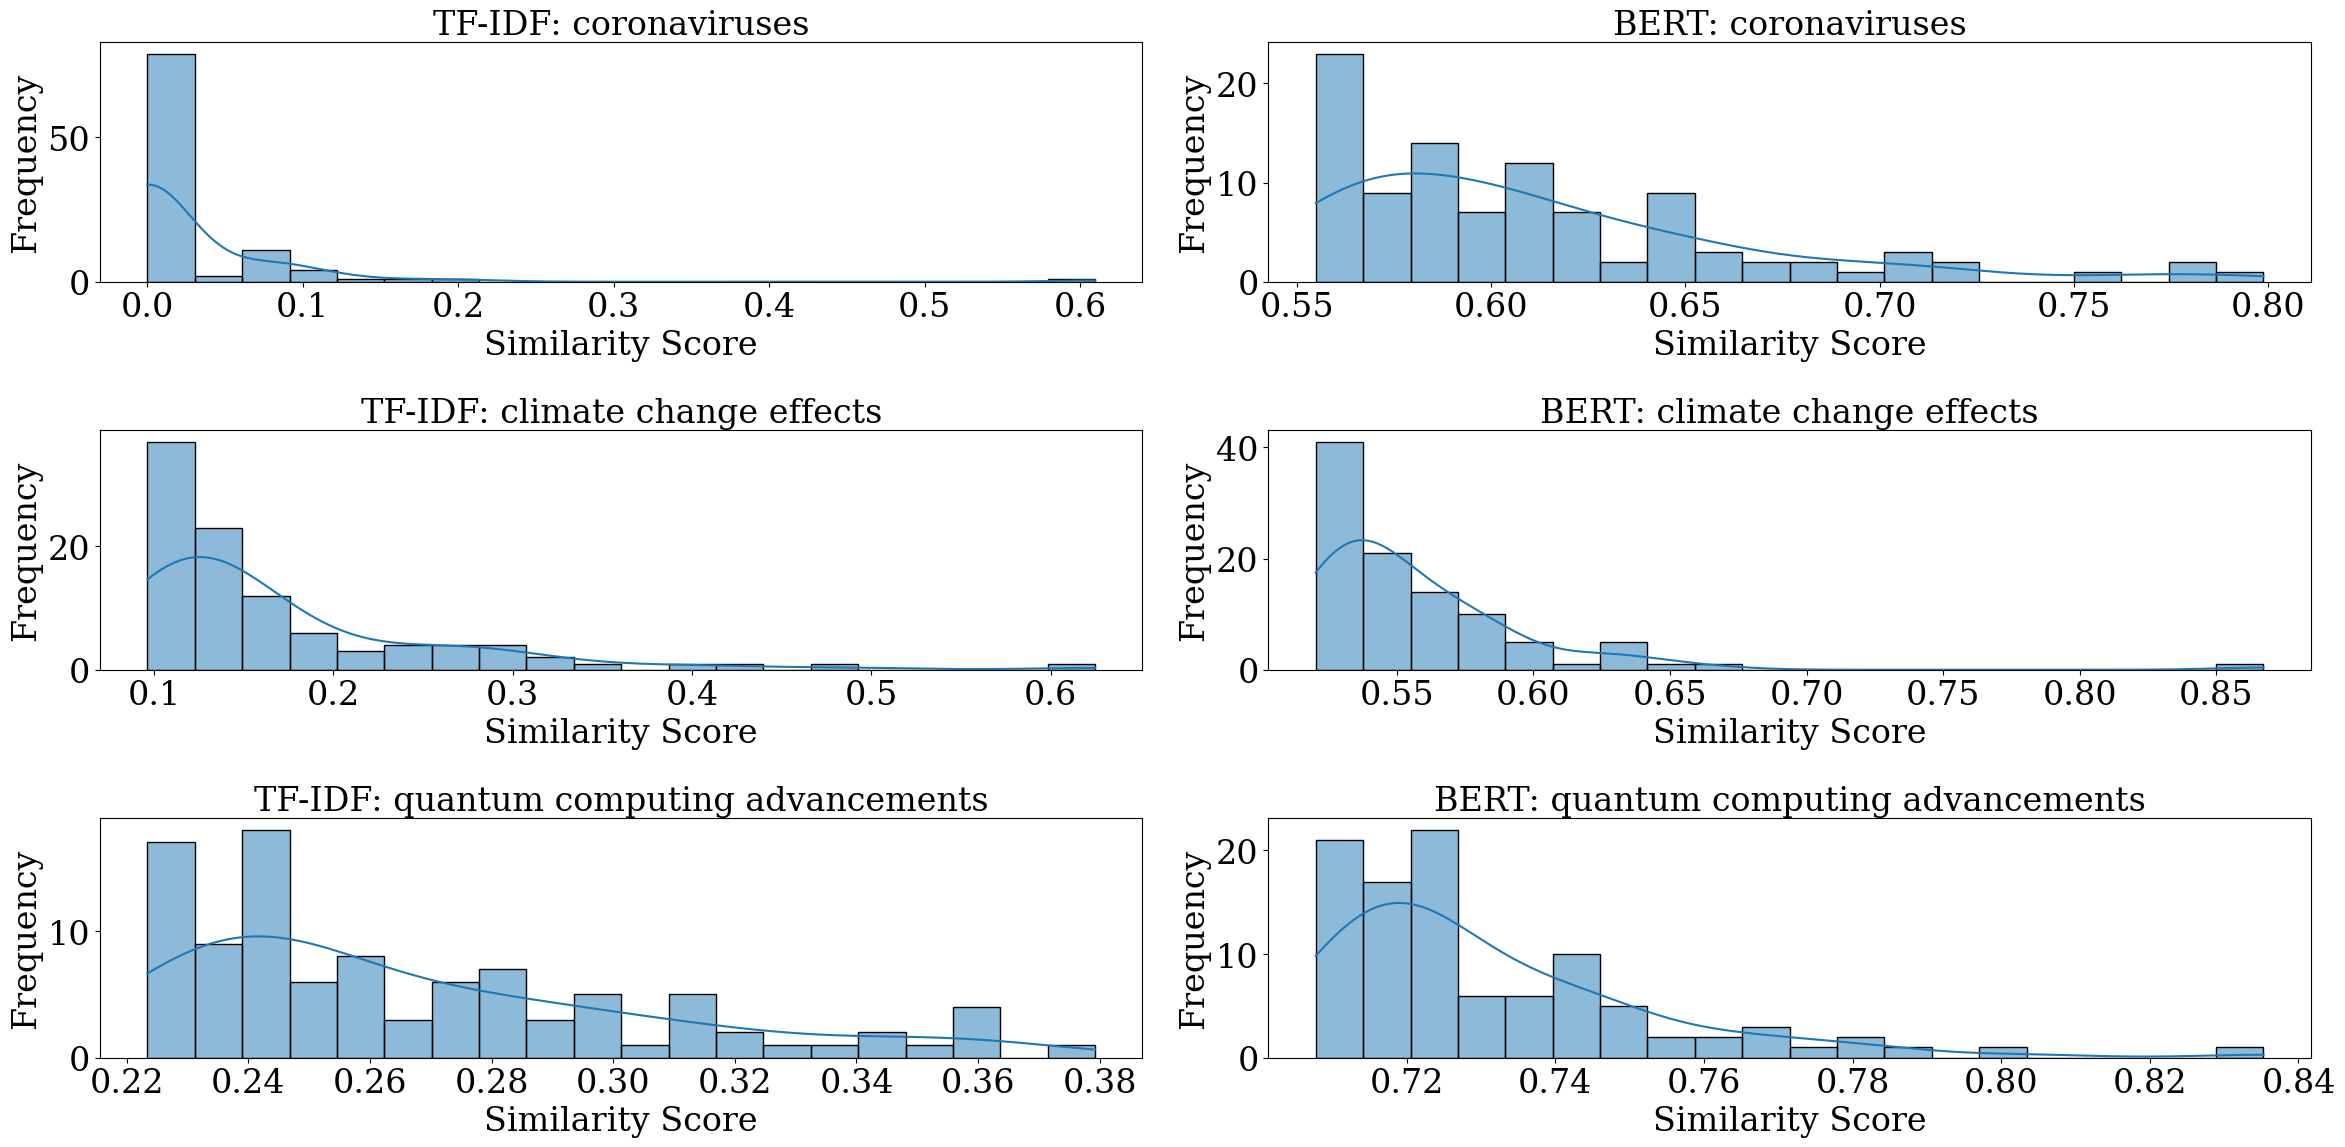

In [ ]:
def plot_similarity_distributions(tfidf_results, bert_results):
    fig, axes = plt.subplots(len(user_queries), 2, figsize=(24, 4 * len(user_queries)))
    for i, query in enumerate(user_queries):
        sns.histplot(tfidf_results[1][i], kde=True, ax=axes[i, 0], bins=20)
        axes[i, 0].set_title(f'TF-IDF: {query}', fontsize=24)
        axes[i, 0].set_xlabel('Similarity Score', fontsize=24)
        axes[i, 0].set_ylabel('Frequency', fontsize=24)

        sns.histplot(bert_results[1][i], kde=True, ax=axes[i, 1], bins=20)
        axes[i, 1].set_title(f'BERT: {query}', fontsize=24)
        axes[i, 1].set_xlabel('Similarity Score', fontsize=24)
        axes[i, 1].set_ylabel('Frequency', fontsize=24)

    plt.tight_layout()
    plt.show()

plot_similarity_distributions(tfidf_results, bert_results)

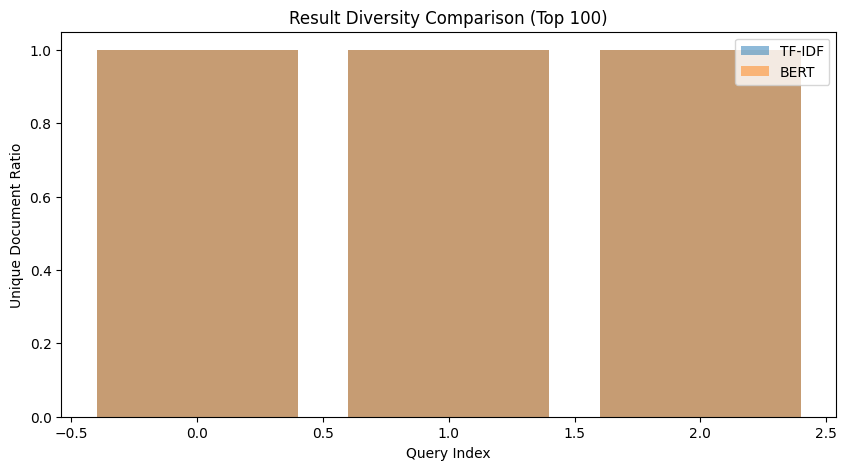

In [ ]:
def analyze_result_diversity(tfidf_results, bert_results):
    def get_unique_ratio(results):
        return [len(set(r)) / len(r) for r in results[0]]

    tfidf_diversity = get_unique_ratio(tfidf_results)
    bert_diversity = get_unique_ratio(bert_results)

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(user_queries)), tfidf_diversity, alpha=0.5, label='TF-IDF')
    plt.bar(range(len(user_queries)), bert_diversity, alpha=0.5, label='BERT')
    plt.xlabel('Query Index')
    plt.ylabel('Unique Document Ratio')
    plt.title('Result Diversity Comparison (Top 100)')
    plt.legend()
    plt.show()

analyze_result_diversity(tfidf_results, bert_results)



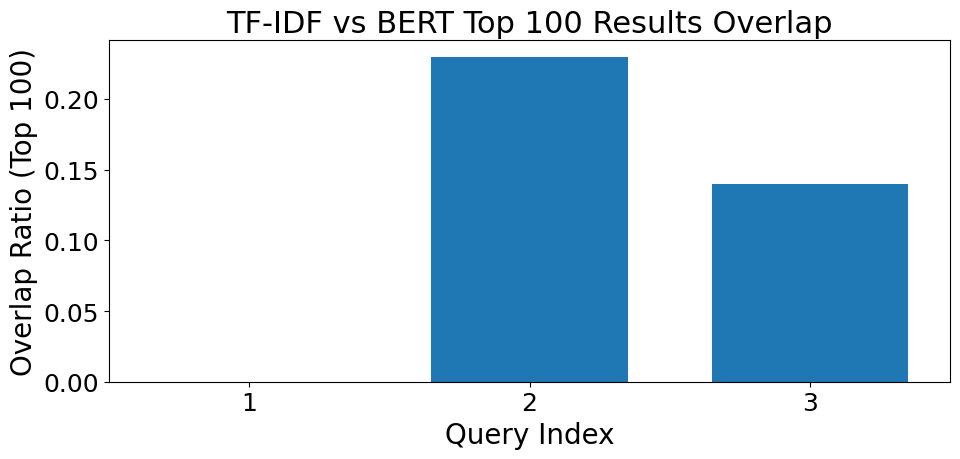

In [ ]:
def plot_top_k_overlap(tfidf_results, bert_results, k=100, fontsize=20):
    overlaps = []
    for tfidf_top, bert_top in zip(tfidf_results[0], bert_results[0]):
        overlap = len(set(tfidf_top[:k]) & set(bert_top[:k])) / k
        overlaps.append(overlap)

    plt.figure(figsize=(10, 5))

    x_positions = list(range(1, len(overlaps) + 1))

    plt.bar(x_positions, overlaps, width=0.7)

    plt.xticks(x_positions, fontsize=fontsize-2)

    plt.xlim(0.5, len(overlaps) + 0.5)

    plt.xlabel('Query Index', fontsize=fontsize)
    plt.ylabel(f'Overlap Ratio (Top {k})', fontsize=fontsize)
    plt.title(f'TF-IDF vs BERT Top {k} Results Overlap', fontsize=fontsize+2)

    plt.yticks(fontsize=fontsize-2)

    plt.rcParams.update({'font.size': fontsize})

    plt.tight_layout()
    plt.show()


plot_top_k_overlap(tfidf_results, bert_results, fontsize=20)



In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def analyze_clustering_quality(embeddings, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, labels)
    return silhouette_avg

tfidf_cluster_quality = analyze_clustering_quality(tfidf_results[3])
bert_cluster_quality = analyze_clustering_quality(bert_results[3])

print(f"TF-IDF Clustering Silhouette Score: {tfidf_cluster_quality}")
print(f"BERT Clustering Silhouette Score: {bert_cluster_quality}")



TF-IDF Clustering Silhouette Score: 0.020341132871146726
BERT Clustering Silhouette Score: 0.07282792031764984


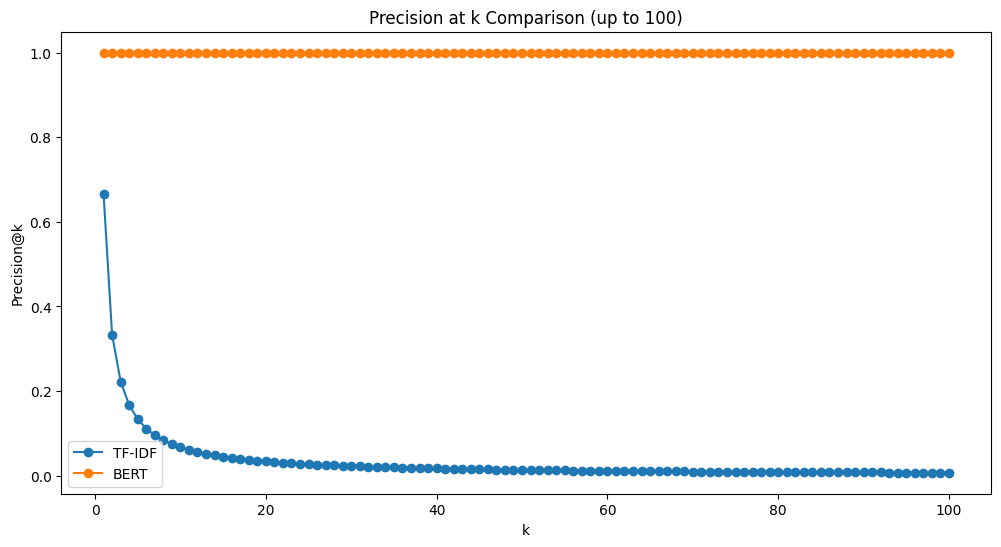

In [ ]:
def plot_precision_at_k(tfidf_results, bert_results, relevance_threshold=0.5):
    k_values = range(1, 101)
    tfidf_precision = []
    bert_precision = []

    for k in k_values:
        tfidf_precision.append(np.mean([np.sum(sim[:k] >= relevance_threshold) / k for sim in tfidf_results[1]]))
        bert_precision.append(np.mean([np.sum(sim[:k] >= relevance_threshold) / k for sim in bert_results[1]]))

    plt.figure(figsize=(12, 6))
    plt.plot(k_values, tfidf_precision, marker='o', label='TF-IDF')
    plt.plot(k_values, bert_precision, marker='o', label='BERT')
    plt.xlabel('k')
    plt.ylabel('Precision@k')
    plt.title('Precision at k Comparison (up to 100)')
    plt.legend()
    plt.show()

plot_precision_at_k(tfidf_results, bert_results)



<ipython-input-9-fae0144bbfc9>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=tfidf_order, x=[tfidf_counts[field] for field in tfidf_order],
<ipython-input-9-fae0144bbfc9>:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=bert_order, x=[bert_counts[field] for field in bert_order],
<ipython-input-9-fae0144bbfc9>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=tfidf_order, x=[tfidf_counts[field] for field in tfidf_order],
<ipython-input-9-fae0144bbfc9>:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and 

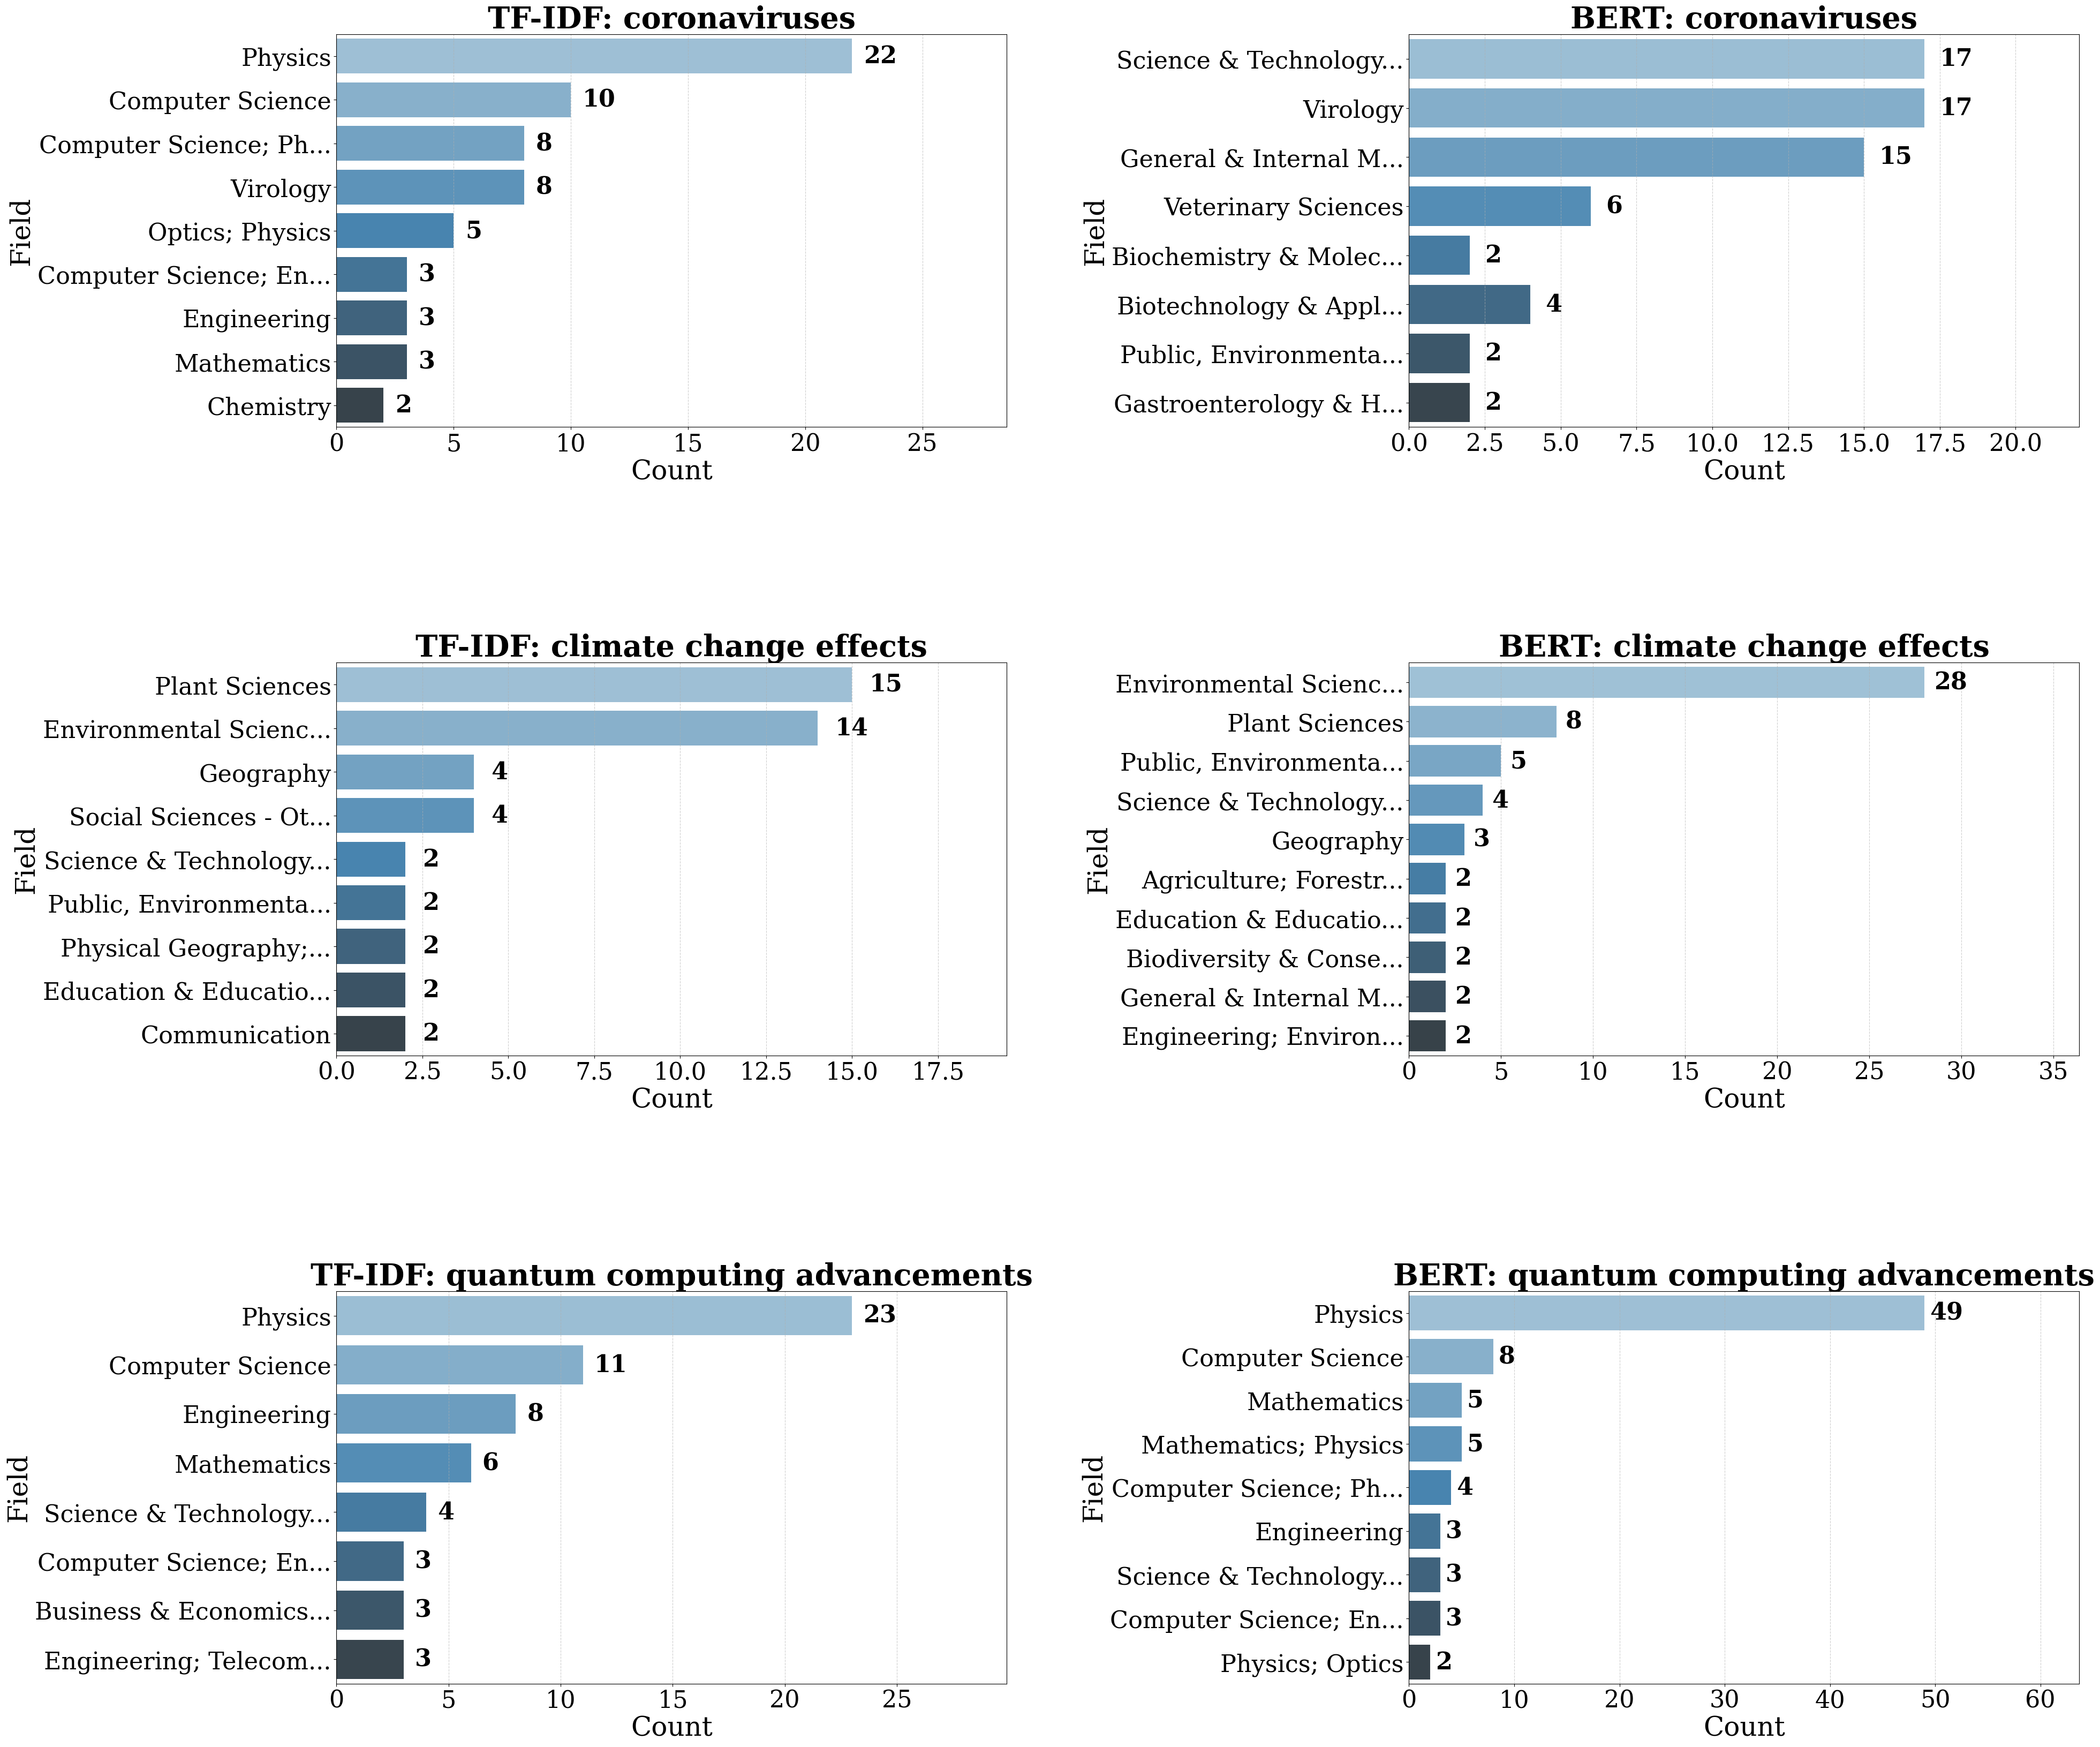

In [ ]:
def analyze_field_coverage(tfidf_results, bert_results, df, user_queries):
    if 'Research Areas' not in df.columns:
        print("No 'Research Areas' column found in the dataframe. Skipping field coverage analysis.")
        return

    def get_fields(indices):
        return [df.iloc[i]['Research Areas'] for i in indices]

    def shorten_field_name(field, max_length=20):

        if len(field) <= max_length:
            return field


        shortened = field[:max_length].strip()


        shortened += "..."

        return shortened

    # Function to shorten query text for title if needed
    def format_query_for_title(query, max_length=30):
        if len(query) <= max_length:
            return query
        return query[:max_length] + "..."

    tfidf_fields = [get_fields(query_results) for query_results in tfidf_results[0]]
    bert_fields = [get_fields(query_results) for query_results in bert_results[0]]


    fig = plt.figure(figsize=(42, 40))


    num_queries = len(user_queries)
    gs = fig.add_gridspec(num_queries, 2, hspace=0.6, wspace=0.6)

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams['font.size'] = 24

    for i, (tfidf_f, bert_f) in enumerate(zip(tfidf_fields, bert_fields)):

        query_title = format_query_for_title(user_queries[i])


        tfidf_order_orig = sorted(set(tfidf_f), key=lambda x: tfidf_f.count(x), reverse=True)[:10]
        tfidf_order = [shorten_field_name(field) for field in tfidf_order_orig]

        tfidf_counts = {}
        for original, shortened in zip(tfidf_order_orig, tfidf_order):
            tfidf_counts[shortened] = tfidf_f.count(original)

        ax1 = fig.add_subplot(gs[i, 0])
        sns.barplot(y=tfidf_order, x=[tfidf_counts[field] for field in tfidf_order],
                   ax=ax1, palette='Blues_d', orient='h')

        ax1.set_title(f'TF-IDF: {query_title}', fontsize=40, fontweight='bold')
        ax1.set_xlabel('Count', fontsize=36)
        ax1.set_ylabel('Field', fontsize=36)
        ax1.tick_params(axis='y', labelsize=32)
        ax1.tick_params(axis='x', labelsize=32)

        for j, p in enumerate(ax1.patches):
            width = p.get_width()
            ax1.text(width + 0.5, p.get_y() + p.get_height()/2,
                    f'{int(width)}', ha='left', va='center', fontsize=32, fontweight='bold')

        max_count = max(tfidf_counts.values())
        ax1.set_xlim(0, max_count * 1.3)

        bert_order_orig = sorted(set(bert_f), key=lambda x: bert_f.count(x), reverse=True)[:10]
        bert_order = [shorten_field_name(field) for field in bert_order_orig]

        bert_counts = {}
        for original, shortened in zip(bert_order_orig, bert_order):
            bert_counts[shortened] = bert_f.count(original)

        ax2 = fig.add_subplot(gs[i, 1])
        sns.barplot(y=bert_order, x=[bert_counts[field] for field in bert_order],
                   ax=ax2, palette='Blues_d', orient='h')

        ax2.set_title(f'BERT: {query_title}', fontsize=40, fontweight='bold')
        ax2.set_xlabel('Count', fontsize=36)
        ax2.set_ylabel('Field', fontsize=36)
        ax2.tick_params(axis='y', labelsize=32)
        ax2.tick_params(axis='x', labelsize=32)

        for j, p in enumerate(ax2.patches):
            width = p.get_width()
            ax2.text(width + 0.5, p.get_y() + p.get_height()/2,
                    f'{int(width)}', ha='left', va='center', fontsize=32, fontweight='bold')

        max_count = max(bert_counts.values())
        ax2.set_xlim(0, max_count * 1.3)

        ax1.grid(axis='x', linestyle='--', alpha=0.6)
        ax2.grid(axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout(pad=4.0)

    plt.savefig('field_coverage_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
analyze_field_coverage(tfidf_results, bert_results, df, user_queries)



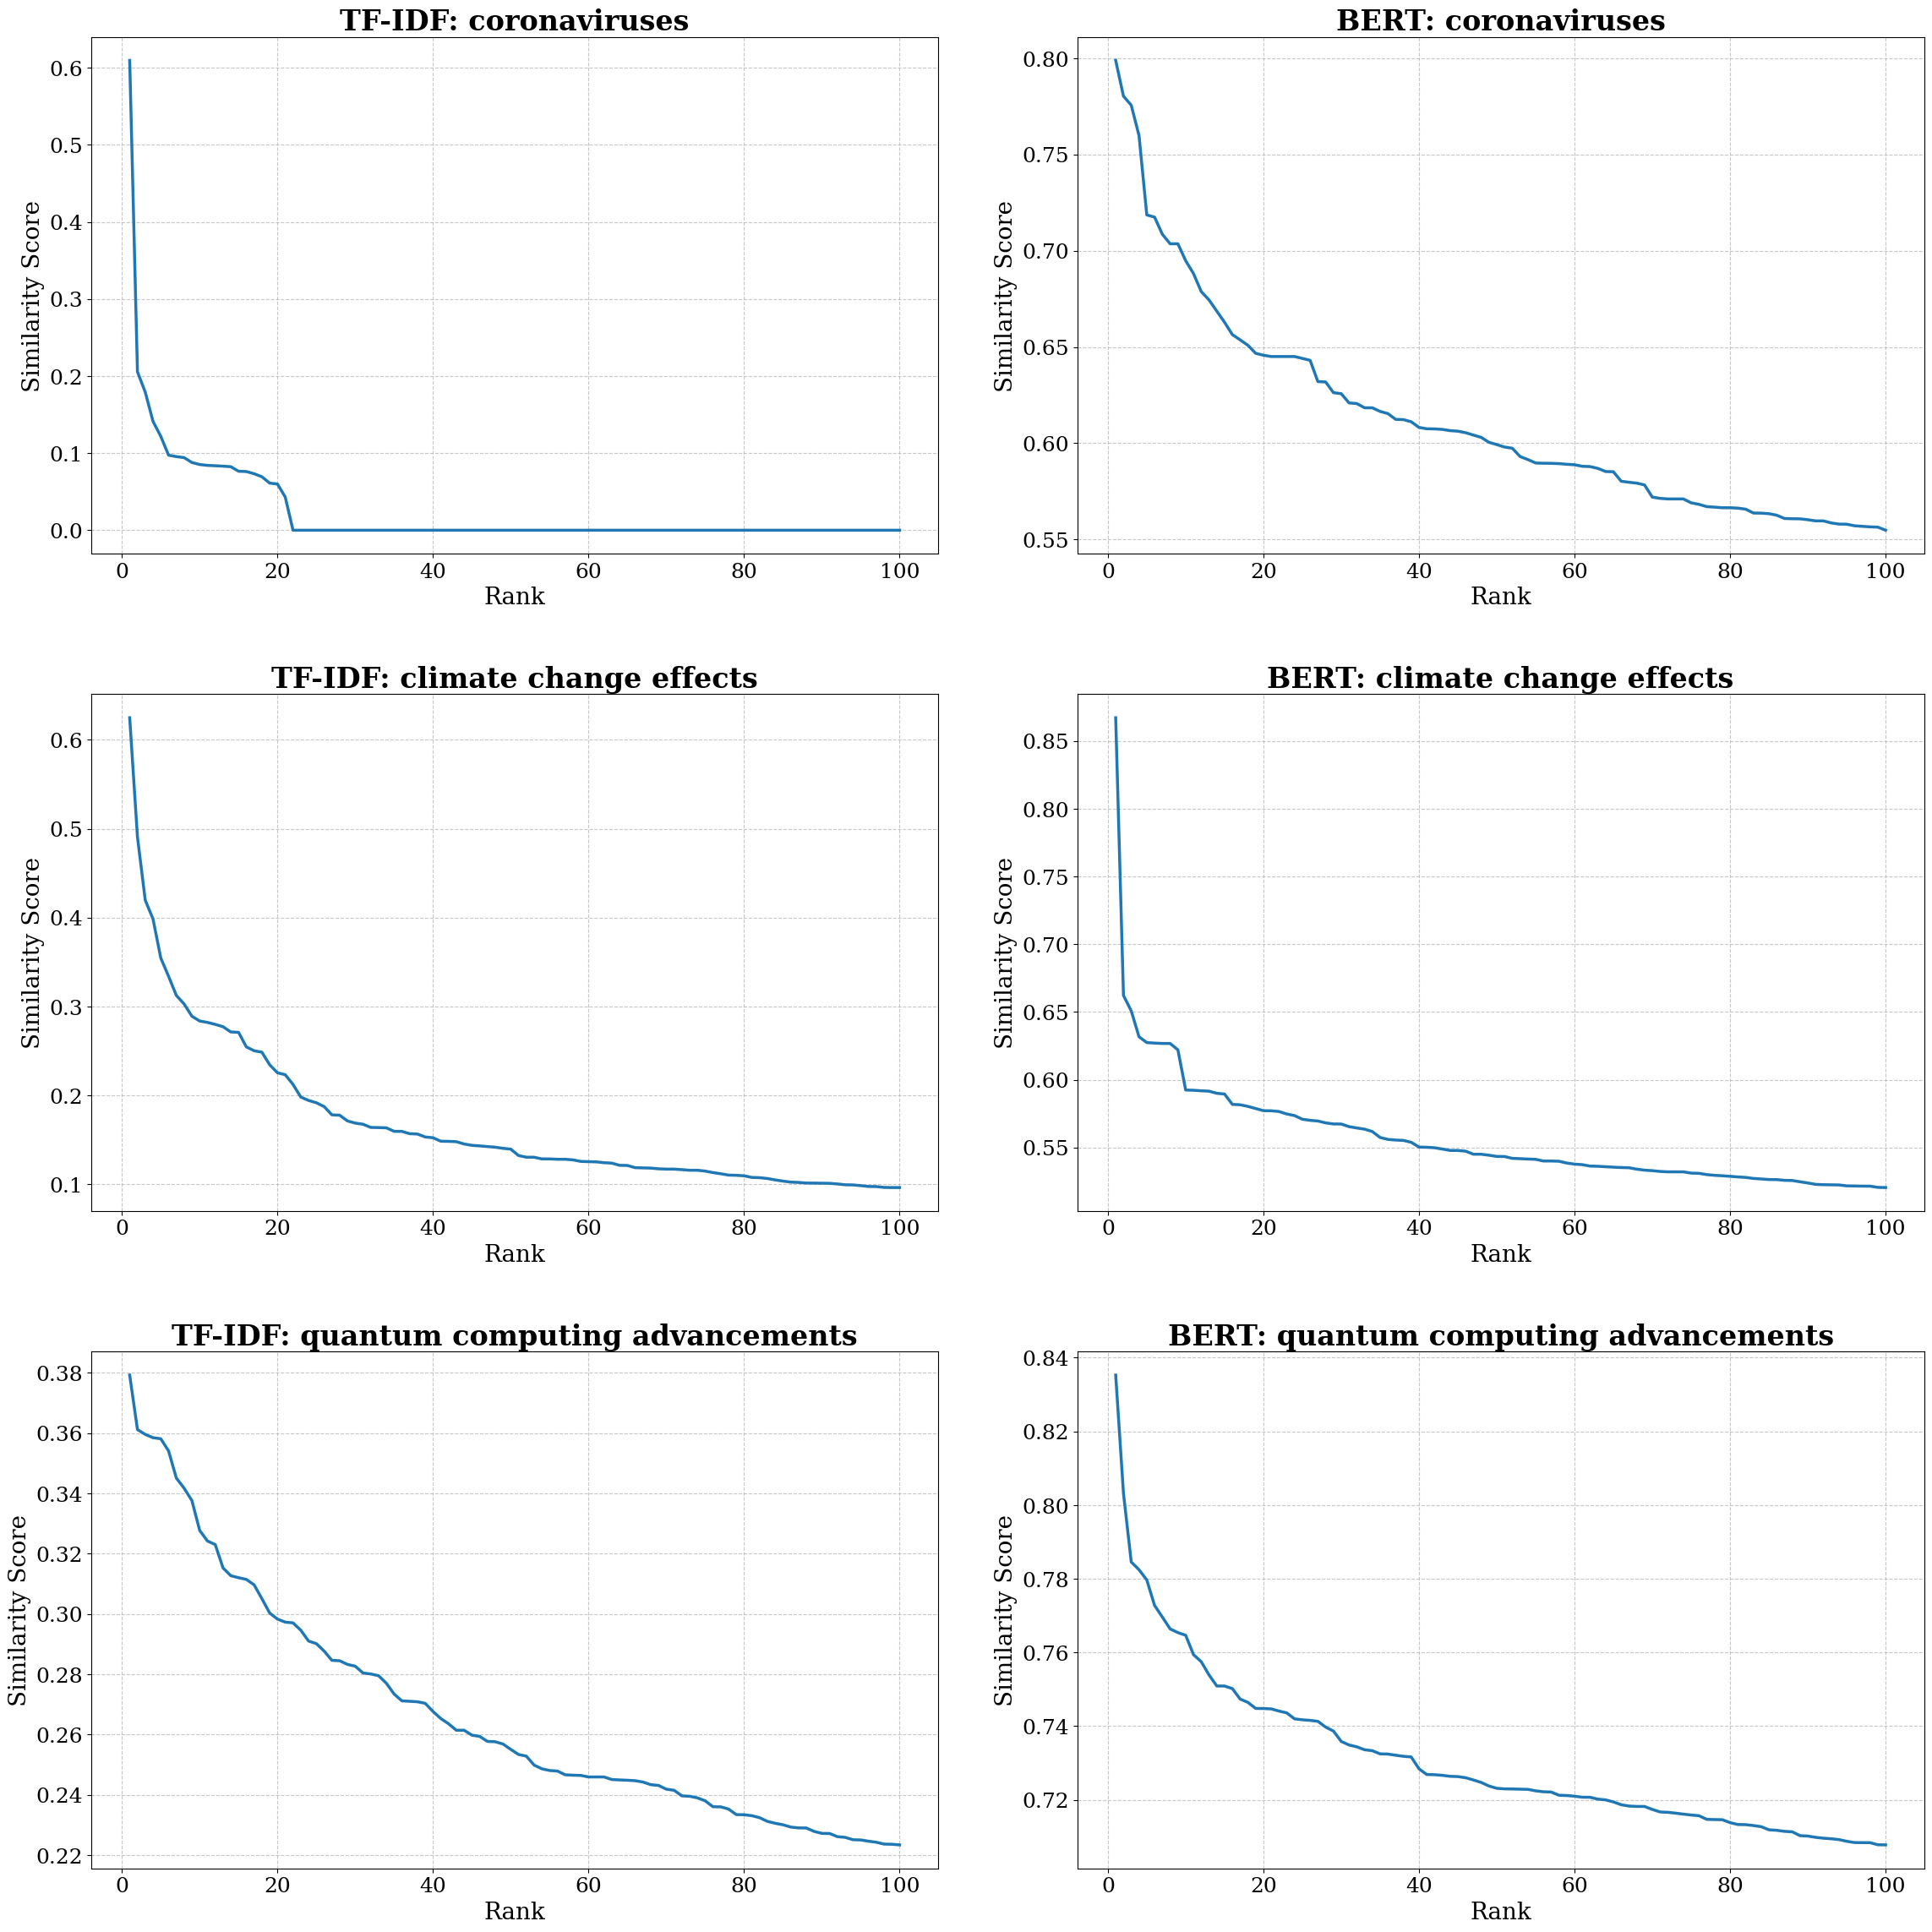

In [ ]:
def plot_similarity_score_decay(tfidf_results, bert_results):
    # Create a larger figure with more space for each subplot
    fig, axes = plt.subplots(len(user_queries), 2, figsize=(24, 8*len(user_queries)))

    # Set publication-quality font
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams['font.size'] = 16  # Increase base font size

    for i, query in enumerate(user_queries):
        # TF-IDF plot with larger fonts
        axes[i, 0].plot(range(1, 101), tfidf_results[1][i], linewidth=2.5)
        axes[i, 0].set_title(f'TF-IDF: {query}', fontsize=24, fontweight='bold')
        axes[i, 0].set_xlabel('Rank', fontsize=20)
        axes[i, 0].set_ylabel('Similarity Score', fontsize=20)
        axes[i, 0].tick_params(axis='both', labelsize=18)
        axes[i, 0].grid(True, linestyle='--', alpha=0.7)

        # BERT plot with larger fonts
        axes[i, 1].plot(range(1, 101), bert_results[1][i], linewidth=2.5)
        axes[i, 1].set_title(f'BERT: {query}', fontsize=24, fontweight='bold')
        axes[i, 1].set_xlabel('Rank', fontsize=20)
        axes[i, 1].set_ylabel('Similarity Score', fontsize=20)
        axes[i, 1].tick_params(axis='both', labelsize=18)
        axes[i, 1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(pad=3.0)  # Add padding to ensure labels don't overlap
    plt.savefig('similarity_score_decay.png', dpi=300, bbox_inches='tight')  # Save high-res version
    plt.show()

plot_similarity_score_decay(tfidf_results, bert_results)

In [ ]:
def plot_execution_time_comparison(tfidf_time, bert_time):
    methods = ['TF-IDF', 'BERT']
    times = [tfidf_time, bert_time]

    plt.figure(figsize=(10, 5))
    plt.bar(methods, times)
    plt.title('Execution Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.show()